# Graph Neural Network (Basics)
1. `URL:` https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
2. `URL:` https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-62acf5b143d0
3. `URL:` http://romain.raveaux.free.fr/document/Semi%20supervised%20learning%20%20Zachary%20s%20club-student-correction.html
4. `URL:` https://petamind.com/an-example-to-graph-convolutional-network/
5. `URL:` https://petamind.com/create-bipartite-graph-from-a-rating-matrix/
6. `URL:` http://romain.raveaux.free.fr/document/A+graph+matching+method+based+on+the+leading+Eigen+vector+and+Sinkhorn-Knopp+algorithm.html
7. `URL:` https://github.com/dbusbridge/gcn_tutorial


A graph convolutional network (GCN) is a neural network that operates on graphs. Given a graph G = (V, E), a GCN takes as input
* an input feature matrix N × F⁰ feature matrix, X, where N is the number of nodes and F⁰ is the number of input features for each node, and
    
* an N × N matrix representation of the graph structure such as the adjacency matrix A of G.

A hidden layer in the GCN can thus be written as `Hⁱ = f(Hⁱ⁻¹, A)` where `H⁰ = X` and `f` is a propagation. Each layer `Hⁱ` corresponds to an `N × Fⁱ` feature matrix where each row is a feature representation of a node. 

At each layer, these features are aggregated to form the next layer’s features using the propagation rule `f`. In this way, features become increasingly more abstract at each consecutive layer. 

In this framework, variants of GCN differ only in the choice of propagation rule `f`.

### A Simple Propagation Rule

One of the simplest possible propagation rule is:

# `f(Hⁱ, A) = σ(AHⁱWⁱ)`

where `Wⁱ` is the weight matrix for layer `i` and `σ` is a non-linear activation function such as the `ReLU` function. 
The weight matrix has dimensions `Fⁱ × Fⁱ⁺¹`; 

**In other words the size of the second dimension of the weight matrix determines the number of features at the next layer.** 
If you are familiar with convolutional neural networks, this operation is similar to a filtering operation since these weights are shared across nodes in the graph.

In [1]:
import numpy as np
# from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
import networkx as nx

### Adjacency Matrix Representation

In [2]:
A = np.matrix([[0, 1, 0, 0],
                [0, 0, 1, 1], 
                [0, 1, 0, 0],
                [1, 0, 1, 0]],dtype=float)
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

### Graph Representation

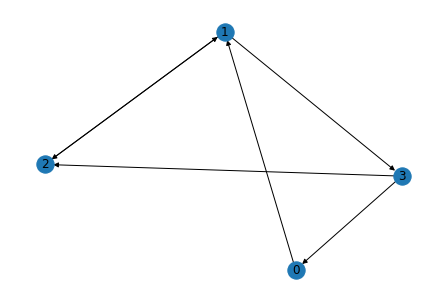

In [3]:
A_graph = nx.DiGraph(A)
nx.draw(A_graph, with_labels=True)
plt.show()

In [4]:
print("Node Degree")
for v in A_graph:
    print(f'{v}    {A_graph.degree(v)}')

Node Degree
0    2
1    4
2    3
3    3


Next, we need features! We generate 2 integer features for every node based on its index. This makes it easy to confirm the matrix calculations manually later.

In [5]:
X = np.matrix([[i, -i] for i in range(A.shape[0])], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

### Applying the Propagation Rule

Alright! We now have a graph, its adjacency matrix A and a set of input features X. Let’s see what happens when we apply the propagation rule:

In [6]:
A * X

matrix([[ 1., -1.],
        [ 5., -5.],
        [ 1., -1.],
        [ 2., -2.]])

What happened? The representation of each node (each row) is now a sum of its neighbors features! In other words, the graph convolutional layer represents each node as an aggregate of its neighborhood. I encourage you to check the calculation for yourself. 

`Note` that in this case a `node n` is a neighbor of `node v` if there exists an **edge** from `v` to `n`.

## Some Problems Here

1. The aggregated representation of a node does not include its own features! The representation is an aggregate of the features of neighbor nodes, so only nodes that has a self-loop will include their own features in the aggregate.
    
2. Nodes with large degrees will have large values in their feature representation while nodes with small degrees will have small values. This can cause vanishing or exploding gradients, but is also problematic for stochastic gradient descent algorithms which are typically used to train such networks and are sensitive to the scale (or range of values) of each of the input features.

### Solving 1st problem: Adding self-loops to each node

In practice this is done by adding the **identity matrix** **`I`** to the **adjacency matrix** **`A`** before applying the propagation rule.

In [7]:
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [8]:
A_hat = A + I
A_hat

matrix([[1., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 1.]])

In [9]:
A_hat * X

matrix([[ 1., -1.],
        [ 6., -6.],
        [ 3., -3.],
        [ 5., -5.]])

Since the node is now a neighbor of itself, the node’s own features is included when summing up the features of its neighbors!

### Solving 2nd Problem: Normalizing the Feature Representations

The feature representations can be normalized by node degree by transforming the **adjacency matrix** **`A`** by multiplying it with the **inverse degree matrix** **`D`**.

### `f(X, A) = D⁻¹AX`

In [10]:
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 1.]])

Before applying the rule, let’s see what happens to the adjacency matrix after we transform it.

In [11]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

In [12]:
A

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.]])

In [13]:
D**-1 * A

matrix([[0. , 1. , 0. , 0. ],
        [0. , 0. , 0.5, 0.5],
        [0. , 0.5, 0. , 0. ],
        [1. , 0. , 1. , 0. ]])

Observe that the weights (the values) in each row of the adjacency matrix have been divided by the degree of the node corresponding to the row. 

We apply the propagation rule with the transformed adjacency matrix and get node representations corresponding to the mean of the features of neighboring nodes. 

This is because the weights in the (transformed) adjacency matrix correspond to weights in a weighted sum of the neighboring nodes’ features.

In [14]:
D**-1 * A * X

matrix([[ 1. , -1. ],
        [ 2.5, -2.5],
        [ 0.5, -0.5],
        [ 2. , -2. ]])

### Putting it All Together

We now combine the **self-loop** and **normalization** tips. In addition, we’ll reintroduce the weights and activation function that we previously discarded to simplify the discussion.

#### Adding back the Weights

First order of business is applying the weights. 

Note that here `D_hat` is the **degree matrix** of `A_hat = A + I`, i.e., the degree matrix of A with forced self-loops.

In [15]:
W = np.matrix([[1, -1],
             [-1, 1]])
W

matrix([[ 1, -1],
        [-1,  1]])

In [16]:
D_hat**-1 * A_hat * X * W

matrix([[ 1., -1.],
        [ 4., -4.],
        [ 2., -2.],
        [ 5., -5.]])

And if we want to reduce the dimensionality of the output feature representations we can reduce the size of the **weight matrix** **`W`**.

In [17]:
W = np.matrix([[1],
             [-1]])
D_hat**-1 * A_hat * X * W

matrix([[1.],
        [4.],
        [2.],
        [5.]])

### Adding an Activation Function

We choose to preserve the dimensionality of the feature representations and apply the ReLU activation function.

In [18]:
def relu(x):
    return np.maximum(x, 0)

In [19]:
W = np.matrix([[1, -1],
             [-1, 1]])
relu(D_hat**-1 * A_hat * X * W)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

### Till now we completed a complete hidden layer with adjacency matrix, input features, weights and activation function

### Now, finally, we can apply a graph convolutional network on a real graph.

### Dataset: Zachary’s Karate Club

Zachary’s karate club is a commonly used social network where nodes represent members of a karate club and the edges their mutual relations. 

### Building the GCN

Now let us build the graph convolutional network. We won’t actually train the network, but simply initialize it at random to produce the feature representations we saw at the start of this post. 

We will use networkx which has a graph representation of the club easily available, and compute the `A_hat` and `D_hat` matrices.

In [20]:
from networkx import karate_club_graph, to_numpy_matrix

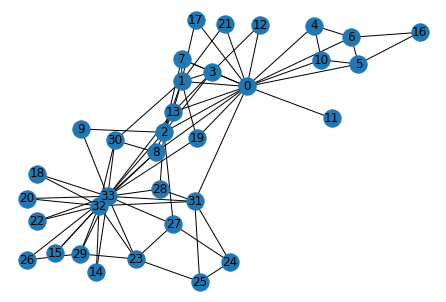

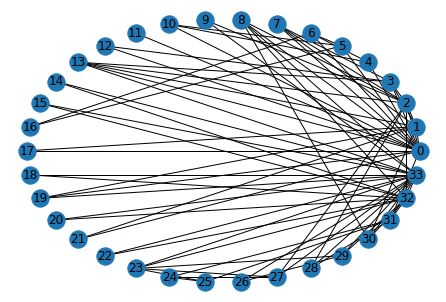

We have 34 nodes.
We have 78 edges.


In [21]:
G = karate_club_graph()
nx.draw(G, with_labels=True)
plt.show()
nx.draw_circular(G, with_labels=True)
plt.show()
print(f'We have {G.number_of_nodes()} nodes.')
print(f'We have {G.number_of_edges()} edges.')

In graph theory, the **degree (or valency)** of a vertex of a graph is the **number of edges that are incident to the vertex**, and **in a multigraph, loops are counted twice**. 

In a regular graph, every vertex has the same degree, and so we can speak of the degree of the graph. 

![Degree Sum Formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/93be0f1259e712a8e9f048788e4e2888bb7f22b0 "Degree Sum Formula")

The degree sum formula states that, given a graph G = ( V , E ).
The formula implies that in any undirected graph, the number of vertices with odd degree is even. 

This statement (as well as the degree sum formula) is known as the handshaking lemma. The latter name comes from a popular mathematical problem, to prove that in any group of people the number of people who have shaken hands with an odd number of other people from the group is even.

In [22]:
print("Node Degree")
for v in G:
    print(f'{v}     {G.degree(v)}')

Node Degree
0     16
1     9
2     10
3     6
4     3
5     4
6     4
7     4
8     5
9     2
10     3
11     1
12     2
13     5
14     2
15     2
16     2
17     2
18     2
19     3
20     2
21     2
22     2
23     5
24     3
25     3
26     2
27     4
28     3
29     4
30     4
31     6
32     12
33     17


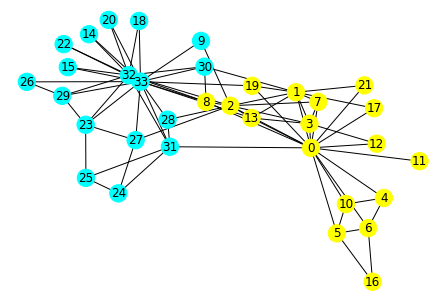

In [23]:
color_map = []
for i in range(len(G.nodes)):
    if G.nodes[i].get('club') == 'Mr. Hi':
        color_map.append('yellow')
    else:
        color_map.append('cyan')
nx.draw_spring(G, node_color=color_map, with_labels=True)
plt.show()

In [24]:
order = sorted(list(G.nodes()))
A = to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

In [25]:
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [26]:
I

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
A_hat

matrix([[1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]])

In [28]:
D_hat

matrix([[17.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 10.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 11., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  7.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., 13.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 18.]])

Next, we’ll initialize weights randomly.

In [29]:
#W_1 with size 34 x 4
W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 4))

#W_2 with size 4 x 2
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

In [30]:
W_1

array([[-1.5003055 ,  1.23619611,  0.95679601,  0.71007496],
       [-1.05792991,  0.54521364,  0.26180987,  2.17514812],
       [ 0.35283054,  1.06451352,  0.82529781, -1.90511406],
       [-0.49848499, -0.45898585, -1.03739446,  0.61728419],
       [ 1.15898269,  0.94579135,  0.71285787,  0.36842927],
       [-1.01625596, -2.27058306, -0.88885175, -0.51425328],
       [-0.7918702 , -0.64193539, -0.6439537 ,  0.54430601],
       [-0.02270926,  0.41278176,  1.14651748,  0.87952172],
       [-0.92625289,  0.36753632,  0.53449276,  0.68813007],
       [-0.21981931,  0.5506544 , -0.39296943,  0.51139742],
       [ 1.01227836, -1.10616027, -0.91430956,  2.64425392],
       [-0.0394187 , -0.92884001,  0.2451555 ,  0.45090754],
       [ 0.52131696,  1.31372031, -0.12513571,  0.62971678],
       [-0.16311156, -0.17936435, -0.02419593,  2.37185012],
       [ 0.65281584, -2.23014127,  0.60582467,  2.10871844],
       [-0.46273534, -0.36645247,  0.53050328, -0.19338091],
       [-0.50783704, -2.

In [31]:
W_2

array([[-0.5699169 , -0.68967448],
       [-0.28811549,  0.33200061],
       [ 1.84972496, -0.24459045],
       [-1.73790105,  0.06713215]])

Stack the GCN layers. We here use just the identity matrix as feature representation, that is, each node is represented as a **one-hot encoded categorical variable**.

In [32]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

In [33]:
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_1

matrix([[0.        , 0.0126277 , 0.        , 0.48246946],
        [0.        , 0.27065679, 0.        , 0.50515053],
        [0.        , 0.62551067, 0.21698066, 0.64515411],
        [0.        , 0.56201073, 0.28624215, 0.78264026],
        [0.        , 0.10847295, 0.02784766, 1.06676604],
        [0.        , 0.        , 0.        , 0.8186884 ],
        [0.        , 0.        , 0.        , 0.36352347],
        [0.        , 0.55994383, 0.43060534, 0.49538299],
        [0.        , 0.73729718, 0.4637696 , 0.33290439],
        [0.17100964, 0.94992663, 0.08524021, 0.        ],
        [0.        , 0.        , 0.        , 0.80212622],
        [0.        , 0.15367805, 0.60097576, 0.58049125],
        [0.        , 0.69697686, 0.        , 0.65235864],
        [0.        , 0.57369751, 0.13428426, 0.8049008 ],
        [0.73771616, 0.        , 0.0946542 , 1.32711384],
        [0.36586576, 0.5052559 , 0.06954707, 0.55974739],
        [0.        , 0.        , 0.        , 0.24637104],
        [0.   

In [34]:
H_2 = gcn_layer(A_hat, D_hat, np.array(H_1, dtype=np.float64), W_2)
H_2

matrix([[0.        , 0.12667561],
        [0.        , 0.18245862],
        [0.        , 0.10163647],
        [0.        , 0.16115168],
        [0.        , 0.05391258],
        [0.        , 0.03726678],
        [0.        , 0.04666032],
        [0.        , 0.12824256],
        [0.        , 0.08566098],
        [0.        , 0.11076794],
        [0.        , 0.06155163],
        [0.        , 0.        ],
        [0.        , 0.16029624],
        [0.        , 0.11614056],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.03196795],
        [0.        , 0.14283262],
        [0.        , 0.        ],
        [0.        , 0.12933505],
        [0.        , 0.        ],
        [0.        , 0.09241642],
        [0.        , 0.00313555],
        [0.        , 0.        ],
        [0.32801582, 0.        ],
        [0.03345695, 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.   

In [35]:
output = H_2

We extract the feature representations

In [36]:
feature_representations = {node: np.array(output)[node] for node in G.nodes()}
feature_representations

{0: array([0.        , 0.12667561]),
 1: array([0.        , 0.18245862]),
 2: array([0.        , 0.10163647]),
 3: array([0.        , 0.16115168]),
 4: array([0.        , 0.05391258]),
 5: array([0.        , 0.03726678]),
 6: array([0.        , 0.04666032]),
 7: array([0.        , 0.12824256]),
 8: array([0.        , 0.08566098]),
 9: array([0.        , 0.11076794]),
 10: array([0.        , 0.06155163]),
 11: array([0., 0.]),
 12: array([0.        , 0.16029624]),
 13: array([0.        , 0.11614056]),
 14: array([0., 0.]),
 15: array([0., 0.]),
 16: array([0.        , 0.03196795]),
 17: array([0.        , 0.14283262]),
 18: array([0., 0.]),
 19: array([0.        , 0.12933505]),
 20: array([0., 0.]),
 21: array([0.        , 0.09241642]),
 22: array([0.        , 0.00313555]),
 23: array([0., 0.]),
 24: array([0.32801582, 0.        ]),
 25: array([0.03345695, 0.        ]),
 26: array([0., 0.]),
 27: array([0., 0.]),
 28: array([0., 0.]),
 29: array([0., 0.]),
 30: array([0.        , 0.0806

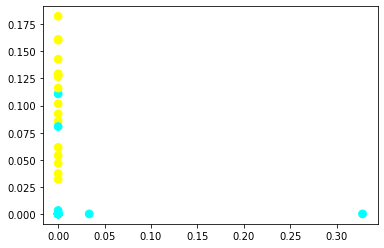

In [37]:
plt.scatter([output[:, 0]], [output[:, 1]], c = color_map, marker='o', s=60)
plt.show()

**Note** that for this example the randomly initialized weights were very likely to give 0 values on either the x- or the y-axis as result of the ReLU function, so it took a few random initializations to produce the figure above.


## RECAP

A simple mathematical framework for expressing propagation in GCNs. In short, given an **`N × F⁰`** **feature matrix** **`X`** and a matrix representation of the graph structure, e.g., the `N × N` **adjacency matrix** `A` of `G`, each hidden layer in the GCN can be expressed as **Hⁱ = f(Hⁱ⁻¹, A))** where **H⁰ = X and f is a propagation rule**. 

Each layer **Hⁱ** corresponds to an **N × Fⁱ** feature matrix where each row is a feature representation of a node.

We saw propagation rules of the form:

1. **f(Hⁱ, A) = σ(AHⁱWⁱ)**, and
2. **f(Hⁱ, A) = σ(D⁻¹ÂHⁱWⁱ)** where **Â = A + I**, *I is the identity matrix*, and *D⁻¹ is the inverse degree matrix of Â*.

These rules compute the feature representation of a node as an aggregate of the feature representations of its neighbors before it is transformed by applying the weights **Wⁱ** and activation function **σ**. 

We can make the aggregation and transformation steps more explicit by expressing propagation rules 1 and 2 above as:

**`f(Hⁱ, A) = transform(aggregate(A,Hⁱ), Wⁱ)`** where **`transform(M, Wⁱ) = σ(MWⁱ)`** and 

For Rule 1:
    **`aggregate(A,Hⁱ) = AHⁱ`**

For Rule 2:
     **`aggregate(A,Hⁱ) = D⁻¹Â Hⁱ`** 

**Aggregation** in rule 1 represents a node as a sum of its neighbors feature representations which has two significant shortcomings:

1. the aggregated representation of a node does not include its own features, and 

2. nodes with large degrees will have large values in their feature representation while nodes with small degrees will have small values, which can lead to issues with exploding gradients and make it harder to train using algorithms such as stochastic gradient descent which are sensitive to feature scaling.

To fix these two issues, **Rule 2** first enforces self loops by adding the **identity matrix** to A and aggregate on using the **transformed adjacency matrix** `Â = A + I`. 

Next, the feature representations are **normalized** by multiplication with the **inverse degree matrix** `D⁻¹`, turning the aggregate into a mean where the scale of the aggregated feature representation is invariant to node degree.

In the following I will refer to rule 1 as the sum rule and rule 2 as the mean rule.